In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.metrics import classification_report
from tqdm import tqdm
from time import time
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split


In [4]:

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X.reshape((X.shape[0], -1))

In [5]:
print(X.shape)
print(X.max(), X.min())

(70000, 784)
255.0 0.0


In [6]:
X[0].reshape(28,28)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

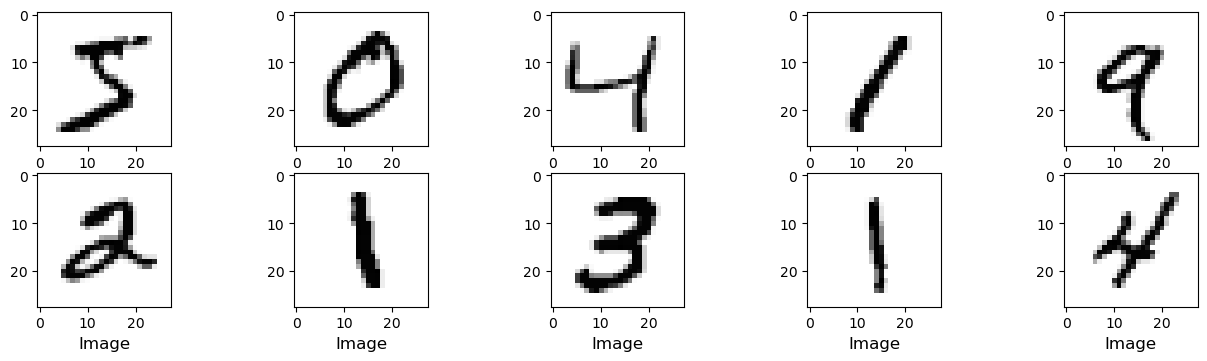

In [7]:
plt.figure(figsize=(16,8))
for i in range(10):
    plt.subplot(4,5, i+1)
    img = X[i].reshape(28,28)
    plt.imshow(img, cmap="Greys")
    plt.xlabel('Image',fontsize = 12)

In [8]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000, random_state = 0
)
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)
data=np.zeros([70000,784])
data[:60000,:]=x_train; data[60000:,:]=x_test
label=np.zeros(70000)
label[:60000]=y_train; label[60000:]=y_test

# data = X
# label = y
print(data.shape, label.shape)

(70000, 784) (70000,)


In [9]:
def naive_bayes(data,label):
    n_s,n_f=data.shape          #Find the Shape (Samples,Features) of the data
    classes=np.unique(label)    #Find the Unique Classes in the Data
    n_c=len(classes)            #Number of Classes in the Data
    
    total_data=np.zeros([n_s,n_f+1]) #Create a Zero Matrix with (Samples,Feature+1) dimensions
    total_data[:,:-1]=data           #Save the samples & features in the total_data matrix
    total_data[:,-1]=label           #Save the Labels in the total_data matrix
    np.random.shuffle(total_data)    #Shuffle the total_data Matrix (Sample & Label) are sampled together
    trainX=total_data[:60000,:]      #Train Data is taken from total Data
    np.random.shuffle(trainX)        #Train Data is shuffled once again        
    testX=total_data[60000:,:]       #Test Data is taken from Total Data
    np.random.shuffle(testX)         #Test Data is shuffled once again
    
    testX_c=testX[:,:-1]             #Take the samples and feature from Test Data
    testX_l=testX[:,-1]              #Take the labels from Test Data
    mean_v=np.zeros([n_c,n_f])       #Take a Zero Matrix that will be used to store the mean of Features wrt classes
    var_v=np.zeros([n_c,n_f])        #Take a Zero Matrix that will be used to store the variance of Features wrt classes
    c_prob=[]                        #list to store P(class)
    confusion_matrix=np.zeros([n_c,n_c]) #Take a Zero Matrix for Confusion MAtrix of size (classes*classes)
    d_acc=[]                         #Take a list that will save each class(digit) accuracy
    
    
    for c in classes:
        trainX_c=trainX[trainX[:,-1]==c]   #Filter samples for each class
        trainX_c=trainX_c[:,:-1]           #
        c_prob.append(len(trainX_c)/len(trainX))
        print(f'no of points in digit class {int(c)}: {trainX_c.shape[0]}')
        mean_v[int(c),:]=trainX_c.mean(axis=0)#Find mean of each class & save in corresonding mean matrix
        var_v[int(c),:]=trainX_c.var(axis=0)#Find variance of each class & save in corresonding mean matrix
    
    var_v=var_v+1000    #Since variance is 0 for many pixels, we need to add some value to the variance. 
                        #Adding 1000 gives one of the best accuracies
    count=0             
    pred_list = []
    for i in range(testX.shape[0]):
        lists=[]   #Empty list to store probability of all class for ith sample feature 
        for j in range(n_c):
            numerator=np.exp(-((testX_c[i]-mean_v[j])**2)/(2*var_v[j])) 
            denominator=np.sqrt(2*np.pi*(var_v[j]))
            prob_xc=numerator/denominator
            ratio=np.sum(np.log(prob_xc)) #Probability of jth class for ith feature
            #We found that all classes have equal counts and P(c) for all class is equal provides better accuracy.
            #The line below can be uncommented to use the original formula
            # ratio=np.sum(np.log(prob_xc)+np.log(c_prob[j]))
            lists.append(ratio) #Append Probability of jth class for ith feature 
        
        pred=lists.index(max(lists)) #Take y predicted for the classthat has the maximum probability for jth feature vector
        pred_list.append(pred)
        if pred == testX_l[i]: 
            count=count+1 #If y_predicted equals true y label,count is incremented
            confusion_matrix[int(testX_l[i])][int(testX_l[i])]=confusion_matrix[int(testX_l[i])][int(testX_l[i])]+1
            #Values in corresponding confusion matrix is appended
        else:
            for k in range(n_c):
                if pred == k:
                    confusion_matrix[int(testX_l[k])][int(testX_l[i])]=confusion_matrix[int(testX_l[k])][int(testX_l[i])]+1
                    #Values in corresponding confusion matrix is appended
    for l in classes:
        check=testX[testX[:,-1]==l] #Filter features for each class
        print(f'class {l}: {confusion_matrix[int(l)][int(l)]}, {check.shape[0]}')
        a=(confusion_matrix[int(l)][int(l)])/float(check.shape[0]) #Find accuracy of each digit
        d_acc.append(a)   #Append individual digit accuracy
    

    o_acc=count/testX.shape[0] #Find overall Accuracy
    return(d_acc,o_acc,confusion_matrix,mean_v,var_v, pred_list, testX_l, testX_c)
    #Return (Digit Accuracy,Overall Accuracy,Confusion Matrix,Mean & Variance)        

In [10]:
#Call Naive Bayes Function
(digit_accuracy,overall_accuracy,matrix,mean_v,var_v, pred_list, testX_l, testX_c)=naive_bayes(data,label)

no of points in digit class 0: 5918
no of points in digit class 1: 6761
no of points in digit class 2: 5955
no of points in digit class 3: 6088
no of points in digit class 4: 5872
no of points in digit class 5: 5436
no of points in digit class 6: 5870
no of points in digit class 7: 6284
no of points in digit class 8: 5872
no of points in digit class 9: 5944
class 0.0: 891.0, 985
class 1.0: 1074.0, 1116
class 2.0: 865.0, 1035
class 3.0: 857.0, 1053
class 4.0: 637.0, 952
class 5.0: 566.0, 877
class 6.0: 926.0, 1006
class 7.0: 818.0, 1009
class 8.0: 851.0, 953
class 9.0: 888.0, 1014


In [11]:
#Print All class Accuracy
digit=['0', '1', '2', '3', '4', '5', '6','7','8','9']
naive_df = pd.DataFrame(list(zip(digit, digit_accuracy)), columns =['Digit','Digit Accuracy (Recall)']) 
print('Digit (Individual Class) Accuracy of the Samples:')
naive_df

Digit (Individual Class) Accuracy of the Samples:


,Digit,Digit Accuracy (Recall)
0,0,0.904569
1,1,0.962366
2,2,0.835749
3,3,0.813865
4,4,0.669118
5,5,0.645382
6,6,0.920477
7,7,0.810704
8,8,0.892970
9,9,0.875740


In [12]:
#Print Overall Accuracy
print('Overall Accuracy of Naive Bayes Model: '+str(overall_accuracy))
overall_accuracy

Overall Accuracy of Naive Bayes Model: 0.8043


0.8043

# Performance Measures


![Performance_Measures](Performance_Measures.png)

### True positive (TP)
- A test result that correctly indicates the presence of a condition or characteristic

### True negative (TN)
- A test result that correctly indicates the absence of a condition or characteristic

### False positive (FP)
- A test result which wrongly indicates that a particular condition or attribute is present

### False negative (FN)
- A test result which wrongly indicates that a particular condition or attribute is absent


## Precision

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations

Precision = TP/(TP+FP)

## Recall

 Recall is the ratio of correctly predicted positive observations to the all observations in actual class 
 
 Recall = TP/(TP+FN)

## f1-score

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

**Think about situations where Precision and Recall play important role as performance metrics**

Ex 1: Spam detection

Ex 2: medical testing


In [13]:
print("Classification Report \n {}".format(classification_report(testX_l, pred_list, labels=range(0,10))))

Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       985
           1       0.77      0.96      0.86      1116
           2       0.90      0.74      0.81      1035
           3       0.83      0.76      0.79      1053
           4       0.83      0.67      0.74       952
           5       0.87      0.65      0.74       877
           6       0.86      0.92      0.89      1006
           7       0.94      0.81      0.87      1009
           8       0.64      0.72      0.68       953
           9       0.63      0.88      0.73      1014

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.80      0.80     10000



In [14]:
print(testX_l.shape, len(pred_list))
print('actual label - ', testX_l[:20])
print('pred label   - ', pred_list[:20])

(10000,) 10000
actual label -  [8. 8. 1. 2. 4. 0. 2. 4. 3. 8. 5. 2. 9. 8. 0. 4. 2. 1. 2. 8.]
pred label   -  [1, 8, 1, 2, 4, 0, 2, 4, 3, 6, 3, 2, 9, 8, 8, 4, 2, 1, 2, 8]


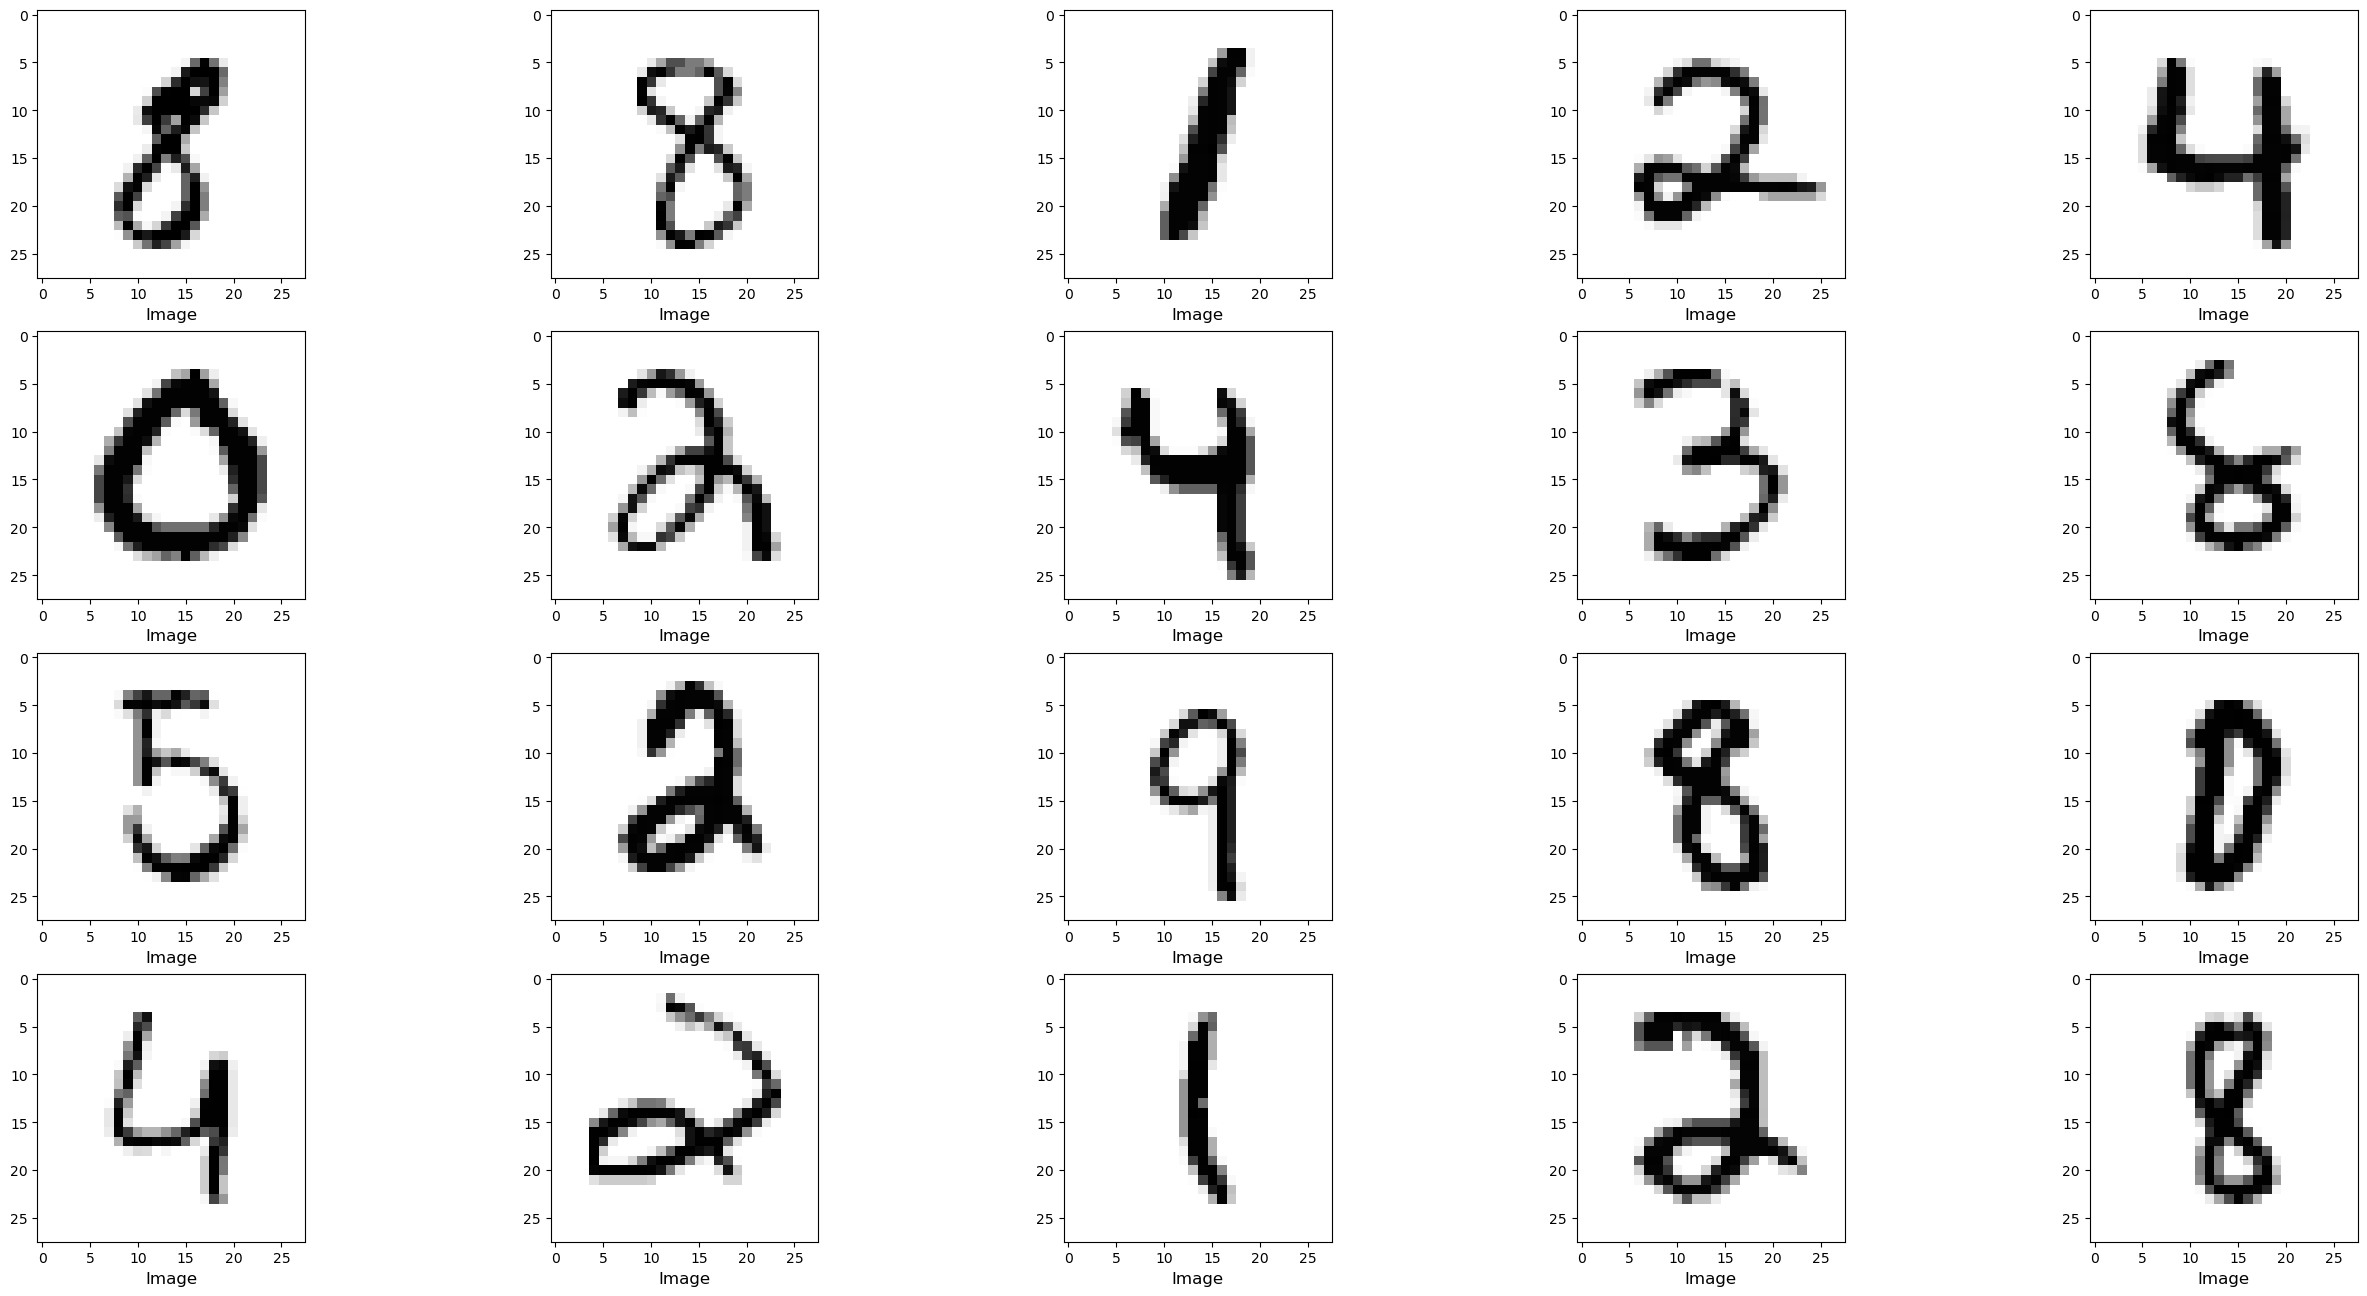

In [15]:
#Print Mean of each Class in 28*28 Form
plt.figure(figsize=(32,16))
for i in range(20):
    plt.subplot(4,5, i+1)
    img = testX_c[i].reshape(28,28)
    plt.imshow(img, cmap="Greys")
    plt.xlabel('Image',fontsize = 12)


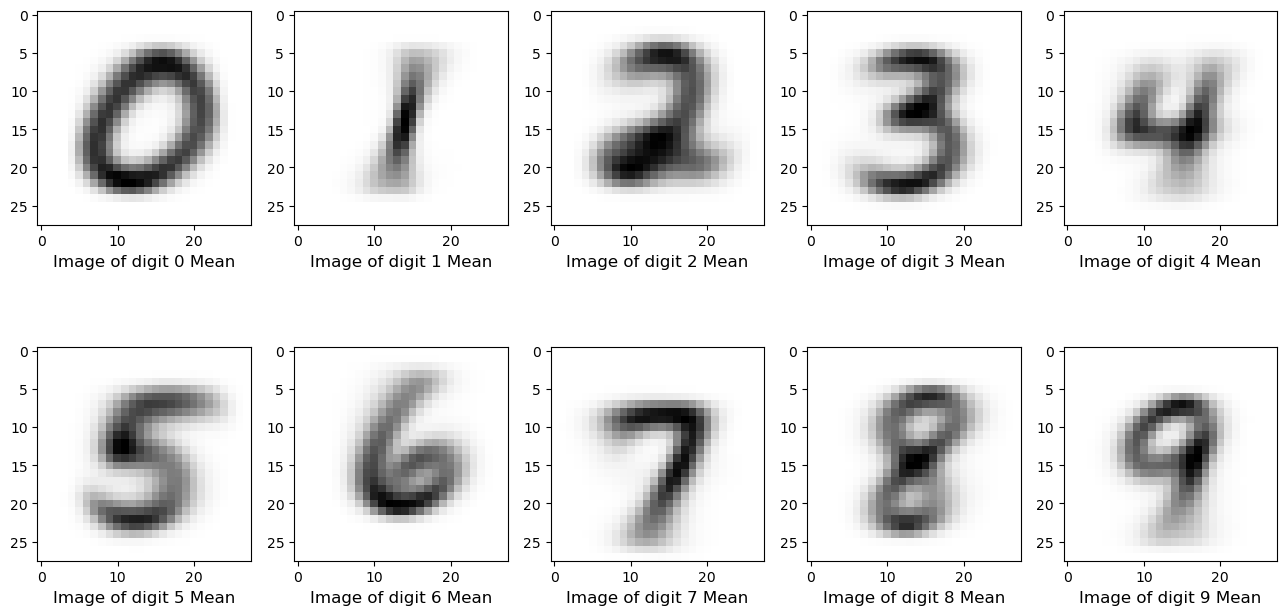

In [16]:
#Print Mean of each Class in 28*28 Form
plt.figure(figsize=(16,8))
for i in range(mean_v.shape[0]):
    plt.subplot(2,5, i+1)
    img = mean_v[i].reshape(28,28)
    plt.imshow(img, cmap="Greys")
    plt.xlabel('Image of digit '+str(i)+' Mean',fontsize = 12)

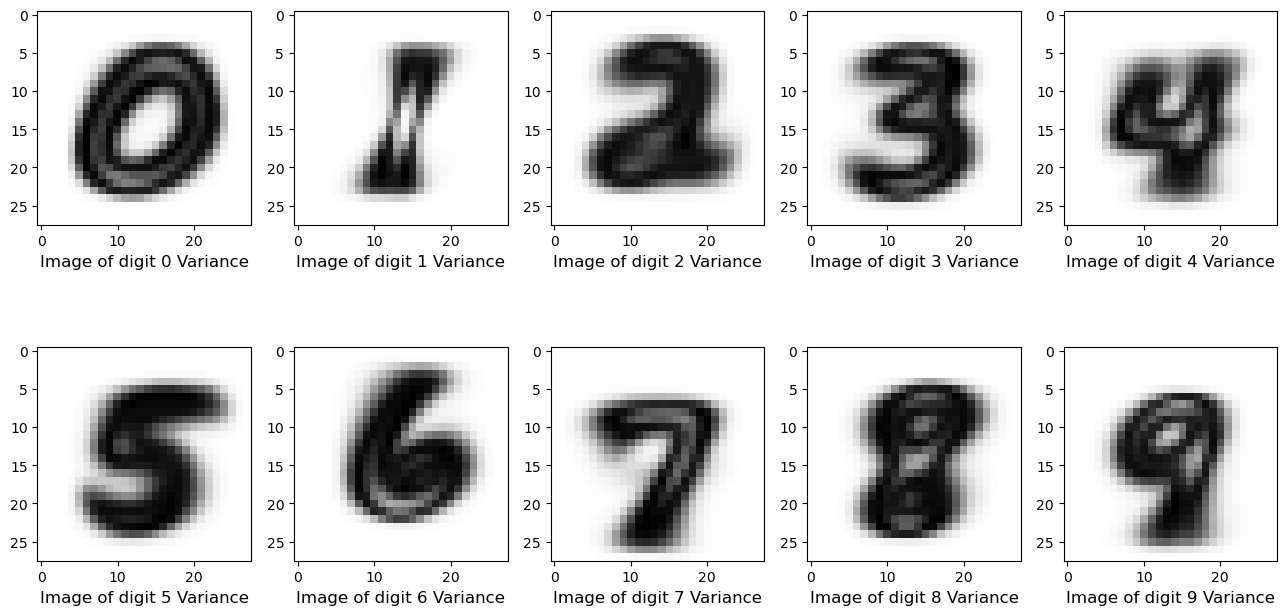

In [17]:
#Print Variance of each Class in 28*28 Form
plt.figure(figsize=(16,8))
for i in range(var_v.shape[0]):
    plt.subplot(2,5, i+1)
    img = var_v[i].reshape(28,28)
    plt.imshow(img, cmap="Greys")
    plt.xlabel('Image of digit '+str(i)+' Variance',fontsize = 12)

Text(195.72222222222223, 0.5, 'Predicted class value')

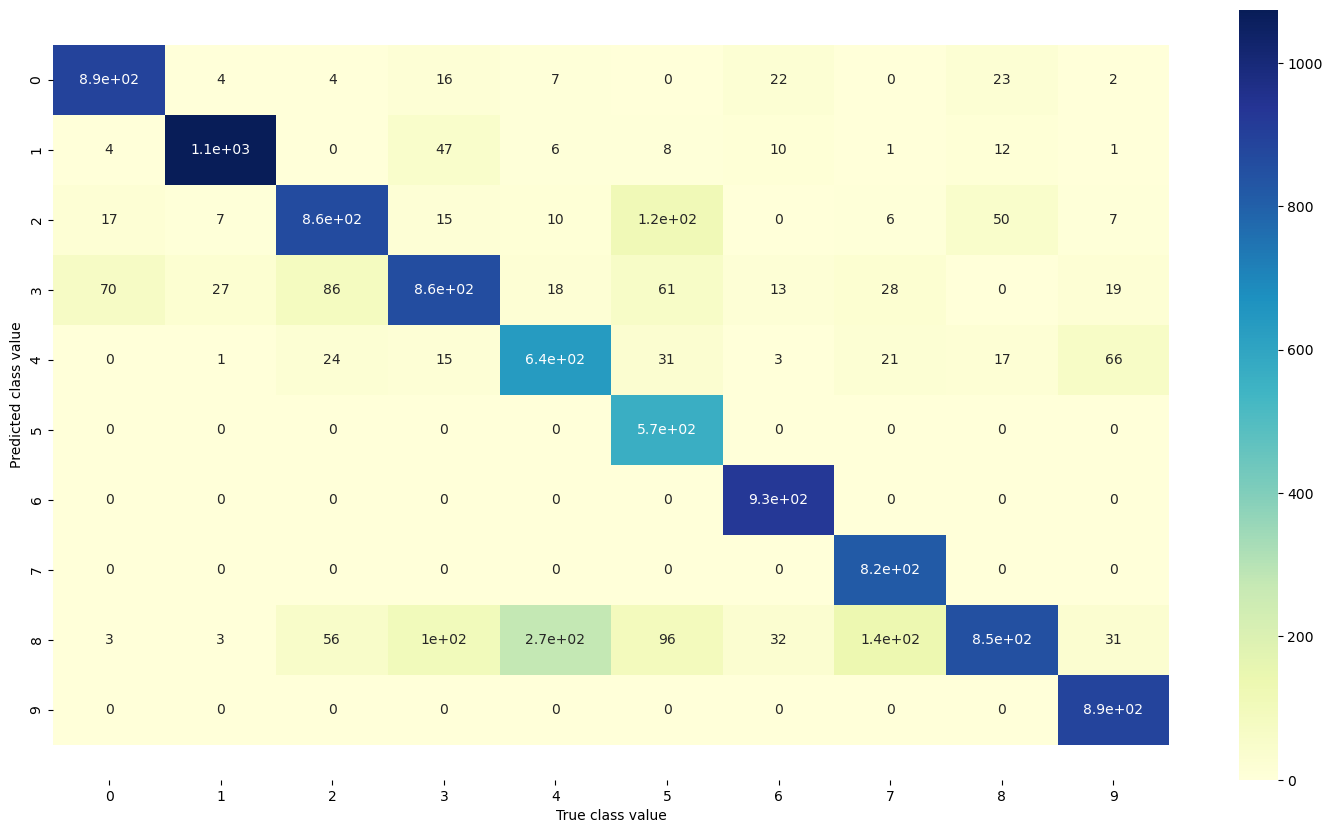

In [18]:
#Print Confusion Matrix
import seaborn as sns
plt.figure(figsize=(18,10))
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(matrix, annot=True, cmap="YlGnBu")
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.xlabel('True class value')
plt.ylabel('Predicted class value')

# References

https://github.com/Arnab-0901/Classification-Algorithms/blob/master/Naive%20Bayes%20on%20MNIST.ipynb

